# Testing a QMPS agent

This notebook demonstrates how to test a successfully trained QMPS agent on different initial states.

In [13]:
import sys
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as ticker

from models import *

### Set up correct RL environment

The RL environment parameters should match the ones used for training.

In [2]:
sys.path.append('../environment/')
import env as environment

env_params = dict(
    L = 16, # system size
    n_time_steps = 50, # maximum number of allowed protocol steps
    n_actions = 12, # action set size
    delta_t = 6, # time step size is: 0.5 * np.pi/delta_t, 0.5 * np.pi/(delta_t + 2.5)
    threshold = 0.03, # reward threshold
    D = 16, # quantum state bond dim
    final_state_params = dict(J=-1.0, gx=0.5, gz=1.5), # target ground state parameters
    random_initial_state=True, # whether to start from fixed or randomly sampled initial states
    reward_function=environment.RewardFunction.LogFidelity,
    random_init_state = environment.InitialState.GroundState,
    seed=123,
)

env = environment.SpinChainEnv(**env_params)

Default device:  TFRT_CPU_0
TS-DMRG sweep=3/200, sites=(0,1)/16: optimized E=(-16+0j)      0459+0j)        

TS-DMRG sweep=3/200, sites=(0,1)/16: optimized E=(-18.479272842407227+0j)      



### Set up and read QMPS agent parameters


In [3]:
model = QMPS.eye(env.L, scale=4.0)

In [4]:
# change to model that you want to test
dir_name = "../trained_models/csC/"
saved_name = "model_n_episodes80000_batch_size64_eps_init1.0_eps_final0.01_eps_decay1.0_target_update10_update_frequency1_D16_learning_rate5e-05_gamma0.98_buffer_size8000_n_feat48_hidden_dim100_uniformFalse_scale4.0_factor4.0_chiq16_seed34_.pkl"

In [5]:
with open(dir_name+saved_name, 'rb') as handle:
    params = pkl.load(handle)
    params = [model.get_tensors(params[0])] + [params[1]]

### Test agent on initial states

As an example we test the agent from control study C on transverse field Ising ground states.

We first need to calculate the ground states via DMRG. Therefore, the cell below takes a bit to run (~2mins).

In [56]:
gz = 0
gx_list = np.linspace(0.1, 2.5, 30)

final_reward_list, rewards_list, steps_list, actions_list, entropy_list = [], [], [], [], []

n_time_steps = env.n_time_steps
# env.n_time_steps = 2*n_time_steps # for testing we can increase the number of allowed environment steps

for i,gx in enumerate(gx_list):
    state, goal = env.reset(gx=gx, gz=gz, testing=True)
    print(i, gx)
    
    done = False
    returns, steps = 0, 0
    actions, rewards = [], []
    rewards.append(env.compute_reward())
    while not done:
        steps +=1

        preds = model.predict_single(params, state)
        a = np.argmax(preds).item()
        actions.append(a)

        state, reward, done, truncation_err, entropy, _  = env.step(a)
        rewards.append(reward)
        returns += reward

    final_reward_list.append(reward)
    steps_list.append(steps)
    entropy_list.append(2*entropy/env.L)
    actions_list.append(actions)
    rewards_list.append(rewards)
    print(done, steps, reward)

TS-DMRG sweep=4/200, sites=(0,1)/16: optimized E=(-15.045036315917969+0j)      

0 0.1
True 29 -0.029636513
TS-DMRG sweep=11/200, sites=(0,1)/16: optimized E=(-15.150657653808594+0j)      

1 0.18275862068965518
True 35 -0.028603818
TS-DMRG sweep=5/200, sites=(0,1)/16: optimized E=(-15.318830490112305+0j)      

2 0.2655172413793103
True 50 -0.18179595
TS-DMRG sweep=4/200, sites=(0,1)/16: optimized E=(-15.550592422485352+0j)      

3 0.34827586206896555
True 50 -0.09423882
TS-DMRG sweep=6/200, sites=(0,1)/16: optimized E=(-15.84744930267334+0j)       

4 0.43103448275862066
True 50 -0.08396747
TS-DMRG sweep=8/200, sites=(0,1)/16: optimized E=(-16.21149253845215+0j)       

5 0.5137931034482759
True 35 -0.029884988
TS-DMRG sweep=9/200, sites=(0,1)/16: optimized E=(-16.645776748657227+0j)      

6 0.596551724137931
True 50 -0.18011485
TS-DMRG sweep=6/200, sites=(0,1)/16: optimized E=(-17.154909133911133+0j)      

7 0.6793103448275862
True 50 -0.11497576
TS-DMRG sweep=7/200, sites=(0,1)/

### Plot results

(red lines enclose training region)

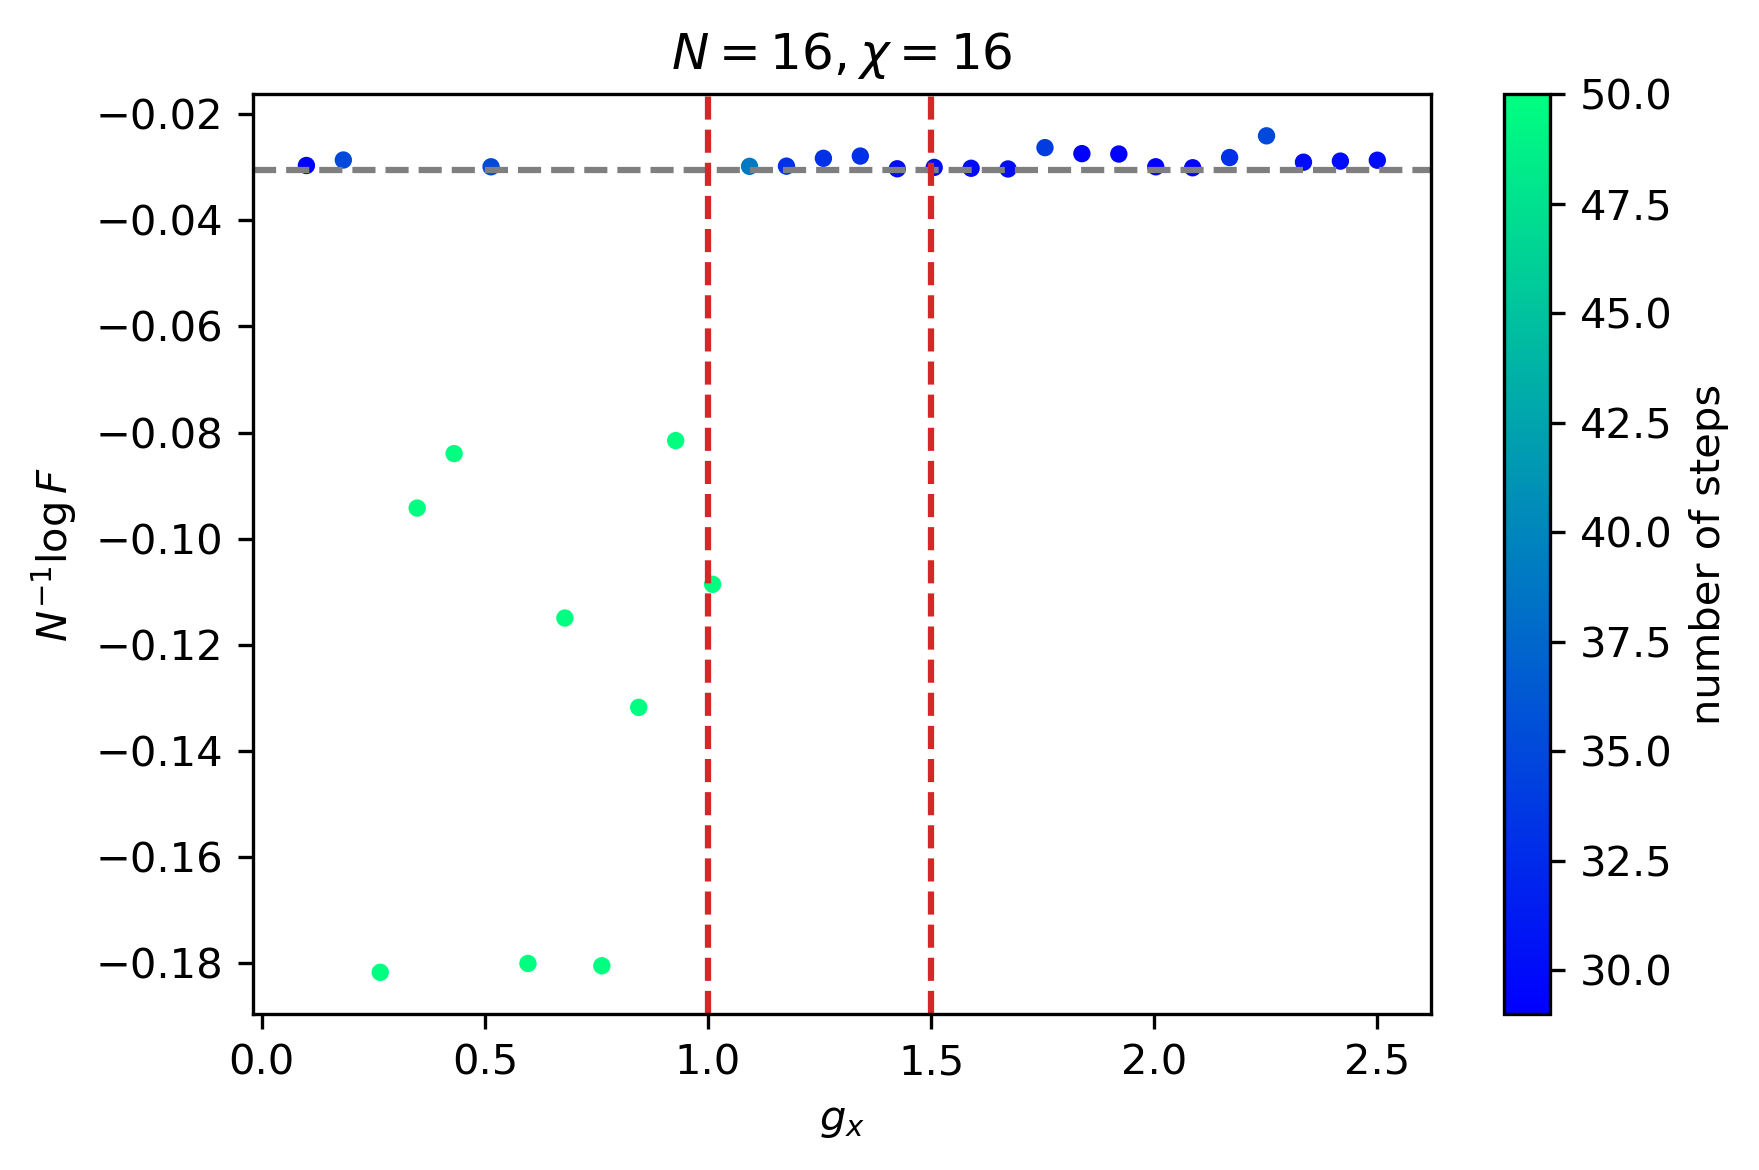

In [57]:
# Final reward (log fidelity), gray dashed line denotes reward threshold
fig, ax = plt.subplots(dpi=300)

plt.title(r"$N=%s, \chi=%s$" %(env.L, env.D))
plt.xlabel(r'$g_x$')
plt.ylabel(r'$N^{-1} \log F$')

cmap = plt.cm.get_cmap('winter')
rmin = np.min(steps_list)
rmax = np.max(steps_list)
c = (steps_list-rmin)/(rmax-rmin)
norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label=r'number of steps')

plt.scatter(gx_list, final_reward_list, s=10, c=steps_list, marker='o', cmap=cmap)
ax.axhline(env.threshold, 0.0, 1.0, color="tab:gray", linestyle='--', linewidth=1.5)

ax.axvline(1.0, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)
ax.axvline(1.5, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)

# plt.ylim(-0.1, 0.0)
plt.tight_layout()
# plt.savefig("reward_test.png")

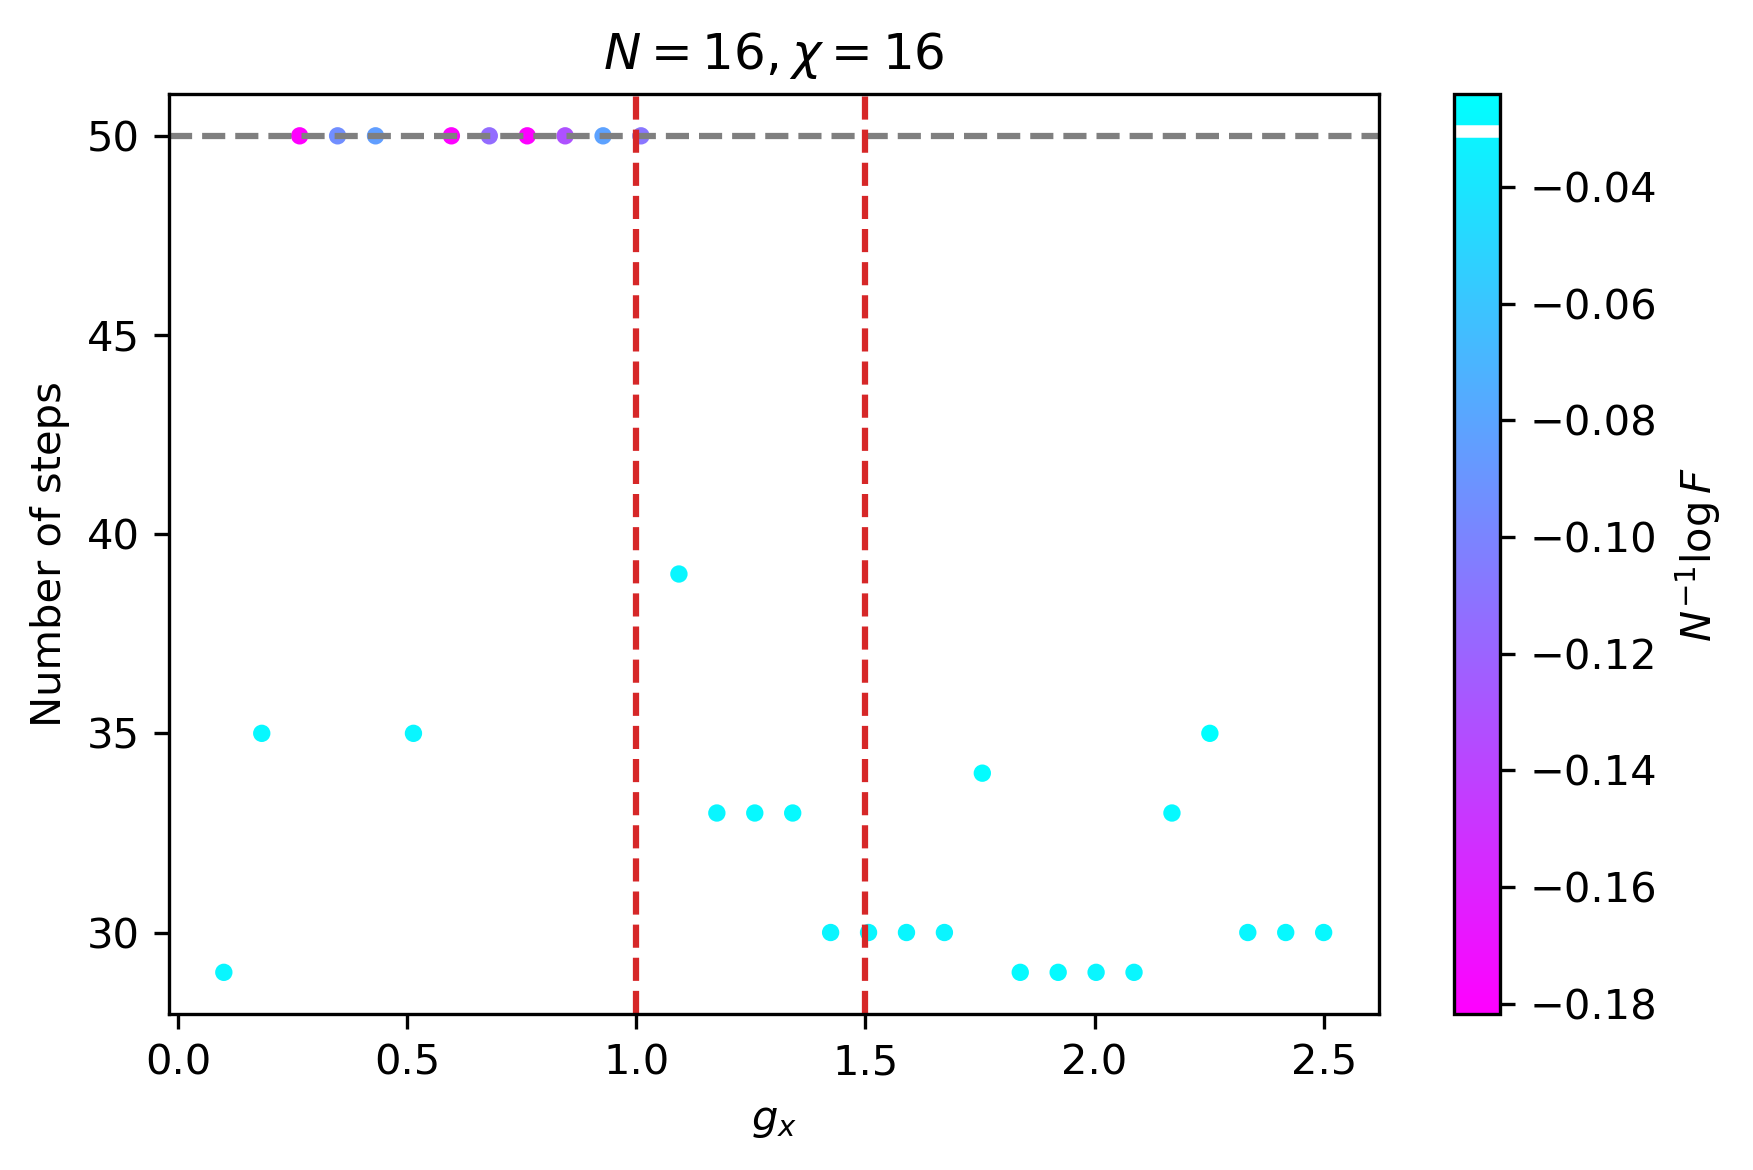

In [58]:
# Number of protocol steps
fig, ax = plt.subplots(dpi=300)

plt.title(r"$N=%s, \chi=%s$" %(env.L, env.D))
plt.xlabel(r'$g_x$')
plt.ylabel('Number of steps')

cmap = plt.cm.get_cmap("cool_r")
rmin = np.min(final_reward_list)
rmax = np.max(final_reward_list)
c = (final_reward_list-rmin)/(rmax-rmin)
if rmax < env.threshold: rmax = env.threshold
norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label=r'$N^{-1} \log F$')
cb.ax.axhline(env.threshold, 0, 1, color = 'w', linestyle = '-', linewidth=3.0)

plt.scatter(gx_list, steps_list, s=10, c=final_reward_list, marker='o', cmap=cmap, vmax =rmax)
ax.axhline(n_time_steps, 0.0, 1.0, color="tab:gray", linestyle='--', linewidth=1.5)

ax.axvline(1.0, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)
ax.axvline(1.5, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)

plt.tight_layout()
# plt.savefig("steps_test.png")

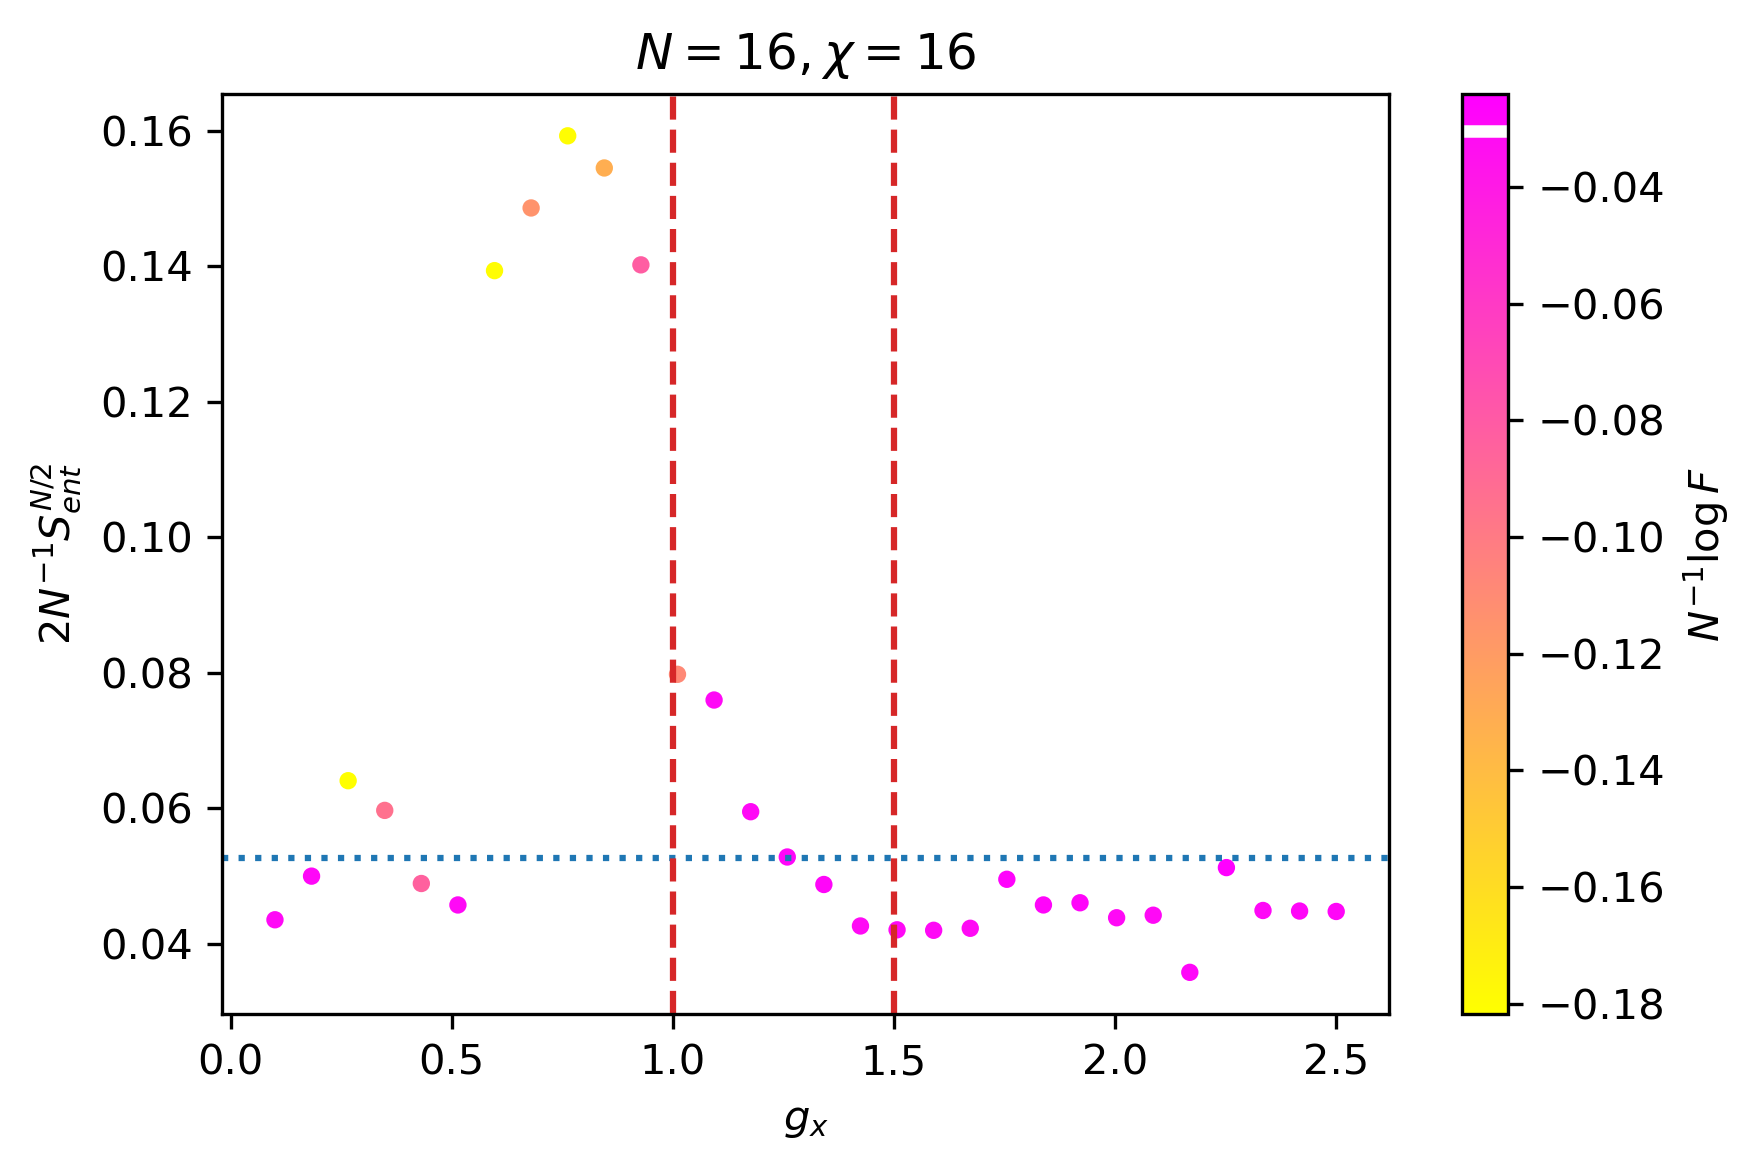

In [59]:
# Entropy of final state (entropy of target state is shown by orange dotted line)
fig, ax = plt.subplots(dpi=300)

plt.title(r"$N=%s, \chi=%s$" %(env.L, env.D))
plt.xlabel(r'$g_x$')
plt.ylabel(r"$2N^{-1}S_{ent}^{N/2}$")

cmap = plt.cm.get_cmap("spring_r")
rmin = np.min(final_reward_list)
rmax = np.max(final_reward_list)
c = (final_reward_list-rmin)/(rmax-rmin)
if rmax < env.threshold: rmax = env.threshold
norm = mpl.colors.Normalize(vmin=rmin, vmax=rmax)
cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label=r'$N^{-1} \log F$')
cb.ax.axhline(env.threshold, 0, 1, color = 'w', linestyle = '-', linewidth=3.0)

target_entropy = 2*env.H_init.entanglement_entropy(env.target_state, env.L//2)/env.L
ax.axhline(target_entropy, 0., 1., color="tab:blue", linestyle='dotted', linewidth=1.5)

plt.scatter(gx_list, entropy_list, s=10, c=final_reward_list, marker='o', cmap=cmap, vmax =rmax)

ax.axvline(1.0, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)
ax.axvline(1.5, 0.0, 1.0, color="tab:red", linestyle='--', linewidth=1.5)

plt.tight_layout()
# plt.savefig("entropy_test.png")

### Plot action sequences

(refer to paper for legend)

In [70]:
i=15
acts = actions_list[i]
rew = rewards_list[i]
tot_steps = len(acts)

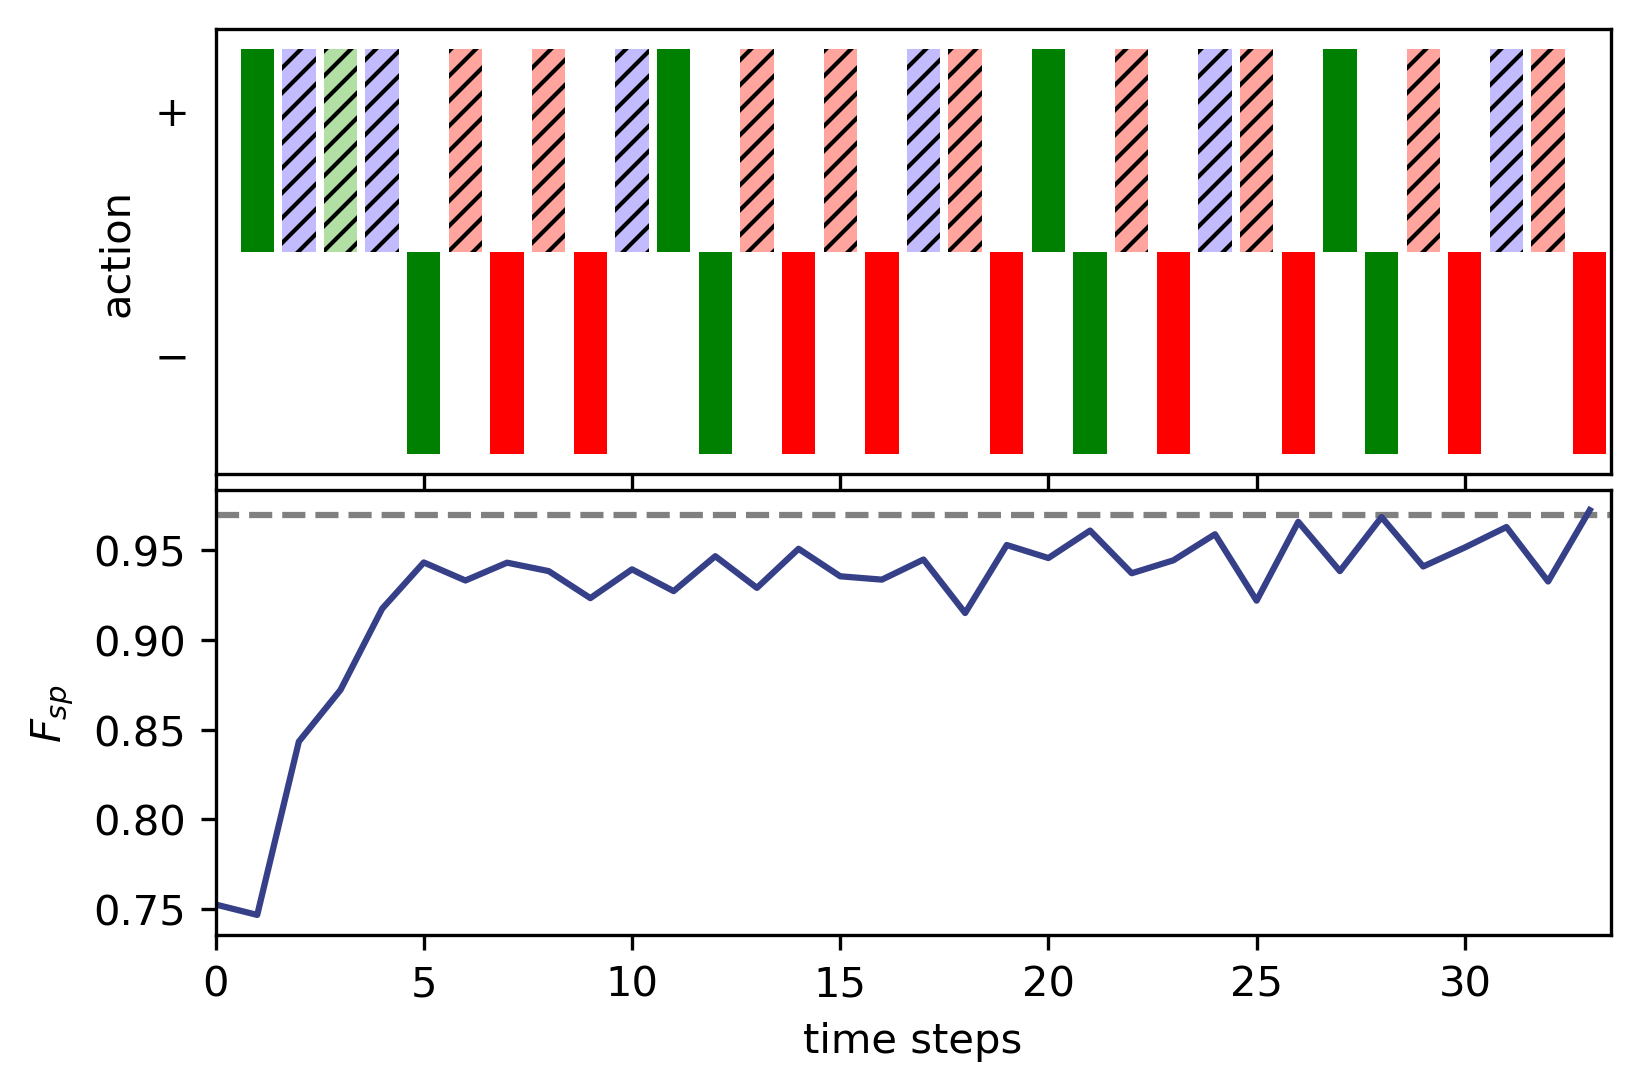

In [71]:
fig,ax = plt.subplots(dpi=300)

colors = ["#C2BCFE", "#C2BCFE", "#B2DFA4", "#B2DFA4", "#FFA59E", "#FFA59E","blue", "blue", "green", "green", "red", "red"]
patterns = ["////"]*6 + [None]*6
alphas = [1.0, 1.0, 0.6, 0.6, 0.2, 0.2] *2

x, y = 10, 1
ax10 = plt.subplot2grid(shape=(x,y), loc=(0, 0), rowspan=5, colspan=1, xticklabels=[])
ax11 = plt.subplot2grid(shape=(x,y), loc=(5, 0), rowspan=5, colspan=1)
colorlist = [colors[int(a)] for a in acts]
alphalist = [alphas[int(a)] for a in acts]
patternlist = [patterns[int(a)] for a in acts]
actions = np.array([(-1)**a for a in acts], dtype=np.float64)

ax10.set_xlim((0, tot_steps+0.5))
ax10.bar(np.linspace(1,tot_steps,tot_steps), actions, color = colorlist, hatch=patternlist, width = 0.8)
ax10.set_ylim(ymin = -1.1, ymax=1.1)
ax10.set_ylabel('action')
ax10.set_yticks([-0.5,0,0.7])
ax10.set_yticklabels([r'$-$','',r'$+$'], minor=False)
ax10.yaxis.set_ticks_position('none')

ax11.set_xlim((0, tot_steps+0.5))
ax11.axhline(np.exp(env.threshold), 0.0, 1.0, color="gray", linestyle='--', linewidth=1.5)
ax11.plot(np.exp(rew), color=color, linewidth=1.5)
ax11.set_ylabel(r'$F_{sp}$')
ax11.set_xlabel("time steps");